Abdulrahman Alabrash

In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data,adam, sigm

In [2]:
using Plots; default(fmt=:png,ls=:auto)

In [3]:
# Load data (see mnist.ipynb)
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata();              # dtrn and dtst = [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

┌ Info: Loading MNIST...
└ @ Main /home/ec2-user/.julia/packages/Knet/05UDD/data/mnist.jl:33


In [4]:
(x,y) = first(dtst)
println.(summary.((x,y)));

28×28×1×100 KnetArray{Float32,4}
100-element Array{UInt8,1}


In [24]:
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(sgd(model,repeat(dtrn,100),lr=0.15))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

## A convolutional neural network model for MNIST

In [25]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = pool(c.f.(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=sigm;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [26]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=identity;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [27]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

where there are three 5x5 filters. Use 2x2 pooling and use sigmoid as activation function. Use stride=1(default) for the conv4 and stride=2(default) for the pool operation. Use padding=0 for the conv4 operation. Feed the output of the pool layer to a softmax classifier. General order of the operations (cbfp) in a convolutional neural network as following:


In [28]:
lenet =   Chain(Conv(5,5,1,3,sigm), 
                Dense(432,10,))
summary.(l.w for l in lenet.layers)
#28-4=24/2=12
#12*12*3*1

2-element Array{String,1}:
 "5×5×1×3 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×432 AutoGrad.Param{KnetArray{Float32,2}}" 

In [29]:
cnn = trainresults("lenet.jld2", lenet);

Train from scratch? stdin> y
2.02e-01  100.00%┣████████████████▉┫ 60000/60000 [02:16/02:16, 440.36i/s]
Float32[0.0632834; 0.0811771; 0.0183833; 0.0267]


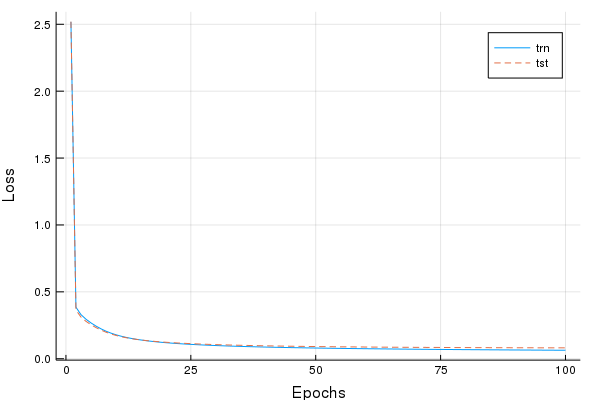

In [30]:
plot([cnn[1,:], cnn[2,:]],#ylim=(0.0,0.5),
     labels=[:trn :tst ],xlabel="Epochs",ylabel="Loss")  

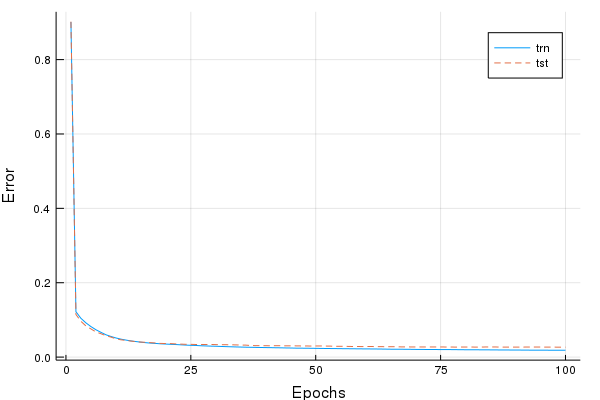

In [32]:
plot([cnn[3,:], cnn[4,:]],#ylim=(0.0,0.5),
     labels=[:trn :tst ],xlabel="Epochs",ylabel="Error")  

#Adam

In [33]:
# For running experiments
function trainresultsAdam(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,100)))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresultsAdam (generic function with 1 method)

In [34]:
lenet1 =   Chain(Conv(5,5,1,3,sigm), 
                Dense(432,10,identity))
summary.(l.w for l in lenet1.layers)

2-element Array{String,1}:
 "5×5×1×3 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×432 AutoGrad.Param{KnetArray{Float32,2}}" 

In [35]:
cnnAdam=trainresultsAdam("cnnAdam.jld2",lenet1)

Train from scratch? stdin> y
1.43e-01  100.00%┣████████████████▉┫ 60000/60000 [02:33/02:33, 391.45i/s]
Float32[0.0510003; 0.07793; 0.0149; 0.0232]


4×100 Array{Float32,2}:
 2.33555  0.511476  0.355175  …  0.0513814  0.0511898  0.0510003
 2.3381   0.492476  0.337464     0.0779335  0.0779398  0.0779451
 0.9228   0.132     0.1006       0.01505    0.0149667  0.0149   
 0.9231   0.1217    0.0922       0.0241     0.0241     0.024    

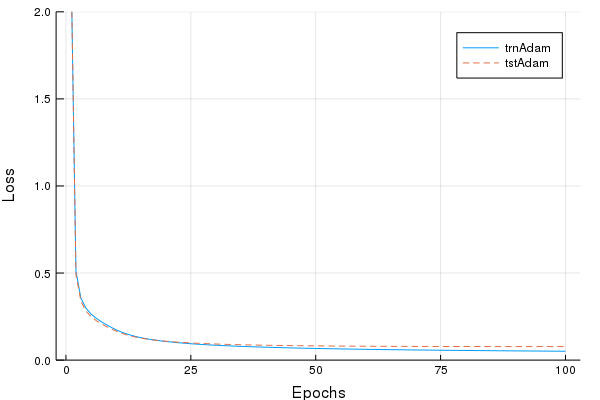

In [36]:
plot([cnnAdam[1,:], cnnAdam[2,:]],ylim=(0.0,2),
     labels=[:trnAdam :tstAdam ],xlabel="Epochs",ylabel="Loss") 

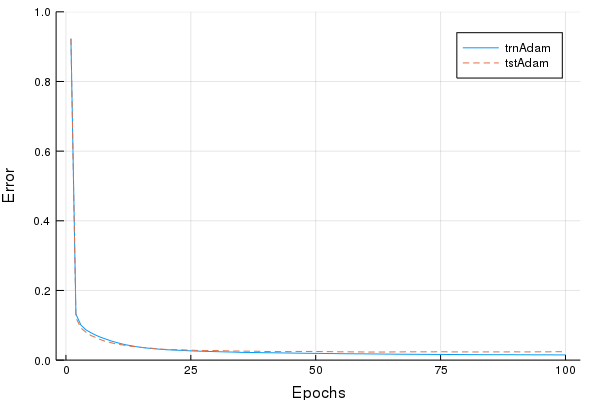

In [37]:
plot([cnnAdam[3,:], cnnAdam[4,:]],ylim=(0.0,1),
     labels=[:trnAdam :tstAdam ],xlabel="Epochs",ylabel="Error") 

#Q7 

In [29]:
lent2=Chain(Conv(3,3,1,20),
            Conv(3,3,20,40),
            Dense(1000,10,identity))
summary.(l.w for l in lent2.layers)


3-element Array{String,1}:
 "3×3×1×20 AutoGrad.Param{KnetArray{Float32,4}}" 
 "3×3×20×40 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×1000 AutoGrad.Param{KnetArray{Float32,2}}"  

Train from scratch? stdin> y
8.88e-04  100.00%┣████████████████▉┫ 60000/60000 [06:08/06:08, 163.02i/s]
Float32[0.00106508; 0.0393716; 0.0002; 0.0114]


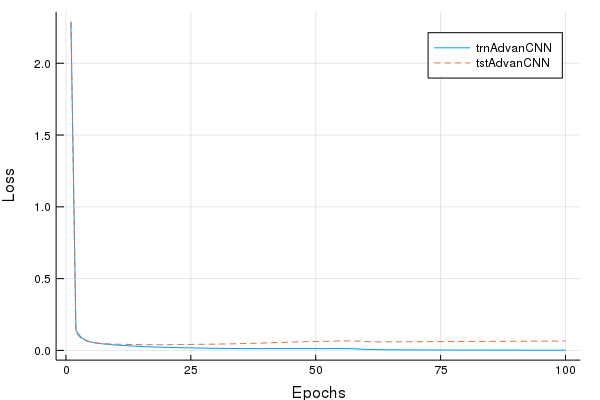

In [30]:
AdvanCNN=trainresults("Advan.jld2",lent2)
plot([AdvanCNN[1,:], AdvanCNN[2,:]],ylim=(0.0,0,6),
     labels=[:trnAdvanCNN :tstAdvanCNN ],xlabel="Epochs",ylabel="Loss")  

Train from scratch? stdin> y
1.97e-01  100.00%┣████████████████▉┫ 60000/60000 [06:03/06:03, 165.38i/s]
Float32[0.0260867; 0.0414616; 0.00735; 0.0131]


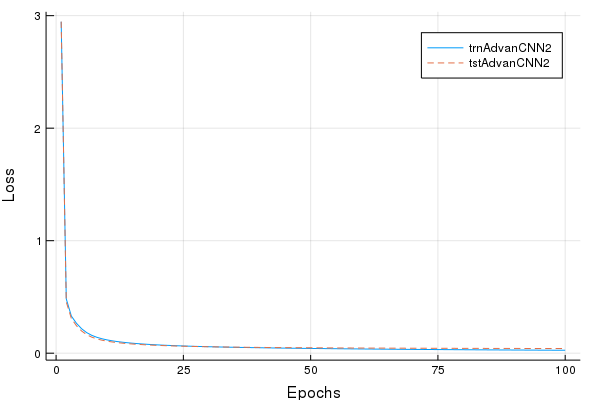

In [39]:
lent3=Chain(Conv(3,3,1,20),
            Conv(3,3,20,40,sigm),
            Dense(1000,10,identity))
summary.(l.w for l in lent3.layers)
AdvanCNN2=trainresults("Advan.jld2",lent3)
plot([AdvanCNN2[1,:], AdvanCNN2[2,:]],ylim=(0.0,0,6),
     labels=[:trnAdvanCNN2 :tstAdvanCNN2 ],xlabel="Epochs",ylabel="Loss")  

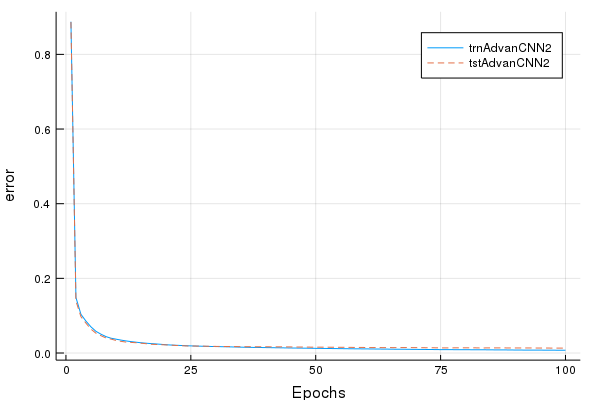

In [40]:
plot([AdvanCNN2[3,:], AdvanCNN2[4,:]],ylim=(0.0,0,6),
     labels=[:trnAdvanCNN2 :tstAdvanCNN2 ],xlabel="Epochs",ylabel="error")  

Train from scratch? stdin> y
2.46e-01  100.00%┣████████████████▉┫ 60000/60000 [09:18/09:18, 107.61i/s]
Float32[0.0255488; 0.0588938; 0.00898333; 0.019]


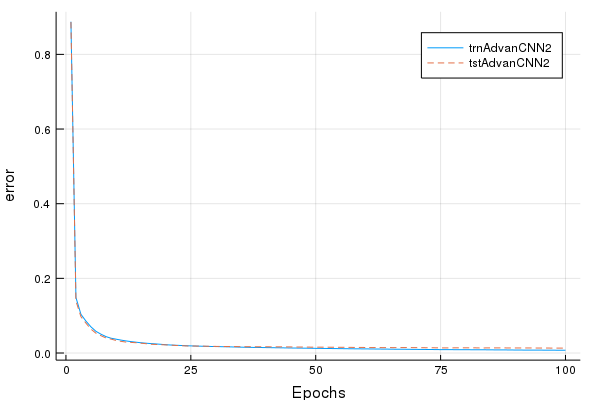

In [42]:
len4=Chain(Conv(3,3,1,20),
            Conv(3,3,20,80),
            Dense(2000,1000,identity),
            Dense(1000,10))

summary.(l.w for l in lent3.layers)
AdvanCNN3=trainresults("Advan.jld2",len4)
plot([AdvanCNN3[1,:], AdvanCNN3[2,:]],ylim=(0.0,0,6),
     labels=[:trnAdvanCNN3 :tstAdvanCNN3 ],xlabel="Epochs",ylabel="Loss")  


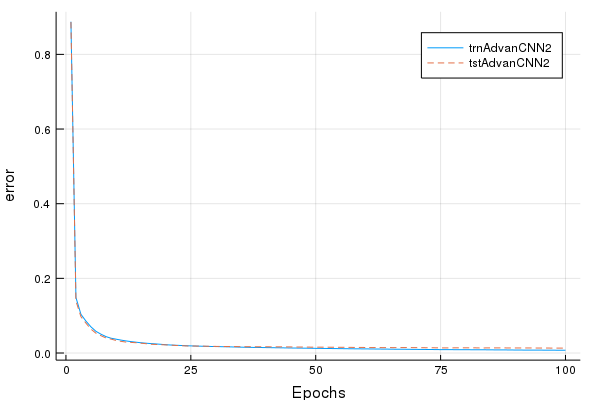

In [43]:
plot([AdvanCNN2[3,:], AdvanCNN2[4,:]],ylim=(0.0,0,6),
     labels=[:trnAdvanCNN2 :tstAdvanCNN2 ],xlabel="Epochs",ylabel="error")  